# BackTapBench: Dataset Standardization

**Purpose**: Create standardized dataset from 5 participants

**Input**: 5 participants × 9 grid positions = 45 CSV files

**Output**: Standardized dataset in `backtapbench_standard/` folder


## 1. Setup and Configuration

In [3]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from collections import defaultdict
import pickle
warnings.filterwarnings('ignore')

# Import detection functions from previous notebook
from tap_detection_functions import detect_taps_in_signal, extract_tap_segments

# Set visual style
plt.style.use('default')
sns.set_palette("husl")

In [45]:
# Notebook directory (where the .ipynb lives)
NOTEBOOK_DIR = Path.cwd().resolve()

# Project root = parent folder of the notebook
BASE_DIR = NOTEBOOK_DIR.parent

DATA_PATH = BASE_DIR / "data"
OUTPUT_PATH = BASE_DIR / "backtapbench_standard"

# Create directories if they don't exist
DATA_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Print to verify
print("NOTEBOOK_DIR:", NOTEBOOK_DIR)
print("BASE_DIR:", BASE_DIR)
print("DATA_PATH:", DATA_PATH)
print("OUTPUT_PATH:", OUTPUT_PATH)

NOTEBOOK_DIR: C:\Users\jumia\Downloads\BackTap\notebooks
BASE_DIR: C:\Users\jumia\Downloads\BackTap
DATA_PATH: C:\Users\jumia\Downloads\BackTap\data
OUTPUT_PATH: C:\Users\jumia\Downloads\BackTap\backtapbench_standard


In [47]:
# CONFIGURATION
PARTICIPANTS = ["participant1", "participant2", "participant3", "participant4", "participant5"]
SENSOR_COLS = ['ax', 'ay', 'az', 'highx', 'highy', 'highz', 'accelmag', 'gx', 'gy', 'gz']

# Tap detection parameters (from notebook 02)
WINDOW_SIZE = 6
Z_ENERGY_THRESHOLD = 3.0
GYRO_THRESHOLD = 1.0
DEBOUNCE_MS = 120
PRE_MS = 60
POST_MS = 200
SAMPLING_RATE = 120

# Derived parameters
PRE_SAMPLES = int(PRE_MS / 1000 * SAMPLING_RATE)
POST_SAMPLES = int(POST_MS / 1000 * SAMPLING_RATE)
DEBOUNCE_SAMPLES = int(DEBOUNCE_MS / 1000 * SAMPLING_RATE)
SEGMENT_LENGTH = PRE_SAMPLES + POST_SAMPLES

print("=" * 60)
print("DATASET STANDARDIZATION CONFIGURATION")
print("=" * 60)
print(f"Input data: {DATA_PATH}")
print(f"Output folder: {OUTPUT_PATH}")
print(f"Participants: {PARTICIPANTS}")
print(f"Segment length: {SEGMENT_LENGTH} samples")
print(f"Sensors: {len(SENSOR_COLS)} channels")
print("=" * 60)

# Create output directory
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, "features"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, "splits"), exist_ok=True)

DATASET STANDARDIZATION CONFIGURATION
Input data: C:\Users\jumia\Downloads\BackTap\data
Output folder: C:\Users\jumia\Downloads\BackTap\backtapbench_standard
Participants: ['participant1', 'participant2', 'participant3', 'participant4', 'participant5']
Segment length: 31 samples
Sensors: 10 channels


## 2. Standardization Class

In [77]:
class BackTapStandardizer:
    """
    Standardizes BackTapBench dataset to consistent format
    """
    
    def __init__(self, data_path=DATA_PATH, output_path=OUTPUT_PATH):
        self.data_path = data_path
        self.output_path = output_path
        self.sensor_cols = SENSOR_COLS
        self.segment_length = SEGMENT_LENGTH
        
        # Data containers
        self.all_segments = []      # List of segment arrays
        self.all_labels = []        # Grid positions (0-8)
        self.all_participants = []  # Participant IDs
        self.all_grids = []         # Grid positions (redundant with labels but useful)
        self.all_trial_nums = []    # Original trial numbers
        self.metadata = []          # Detailed metadata for each segment
        
        # Statistics
        self.stats = {
            'total_segments': 0,
            'segments_per_participant': defaultdict(int),
            'segments_per_grid': defaultdict(int),
            'segment_shapes': []
        }
    
    def process_all_participants(self):
        """
        Process all participants and create standardized dataset
        """
        print("=" * 60)
        print("PROCESSING ALL PARTICIPANTS")
        print("=" * 60)
        
        total_files_processed = 0
        total_segments_extracted = 0
        
        for participant in PARTICIPANTS:
            participant_path = os.path.join(self.data_path, participant)
            print("Looking for:", participant_path)
            
            if not os.path.exists(participant_path):
                print(f"❌ Skipping {participant}: folder not found")
                continue
            
            # Get all CSV files for this participant
            csv_files = sorted([f for f in os.listdir(participant_path) 
                              if f.endswith('.csv')])
            
            print(f"\n📁 Processing {participant}: {len(csv_files)} files")
            
            for file_idx, filename in enumerate(csv_files):
                # Extract grid position from filename
                # Format: participantX_trialYYYY.csv
                try:
                    trial_num = int(filename.split('trial')[1].split('.')[0])
                    grid_position = trial_num - 1  # trial0001 = grid0
                except:
                    print(f"   ⚠️  Could not parse grid from {filename}, using file index")
                    grid_position = file_idx
                
                # Process this file
                segments = self._process_single_file(participant, filename, grid_position)
                
                total_files_processed += 1
                total_segments_extracted += len(segments)
                
                print(f"   Grid {grid_position}: {len(segments)} segments extracted")
        
        print("\n" + "=" * 60)
        print("PROCESSING COMPLETE")
        print("=" * 60)
        print(f"Total files processed: {total_files_processed}")
        print(f"Total segments extracted: {total_segments_extracted}")
        
        # Convert lists to arrays
        self._finalize_data()
        
        return total_segments_extracted
    
    def _process_single_file(self, participant, filename, grid_position):
        """
        Process a single CSV file and extract tap segments
        """
        filepath = os.path.join(self.data_path, participant, filename)
        
        try:
            df = pd.read_csv(filepath)
        except Exception as e:
            print(f"   ❌ Error reading {filename}: {e}")
            return []

        # Normalize column names
        df.columns = df.columns.str.strip().str.lower()
        
        # Calculate gyro magnitude
        gyro_mag = np.sqrt(df['gx']**2 + df['gy']**2 + df['gz']**2)
        
        # Detect taps
        tap_indices = detect_taps_in_signal(
            df['highz'].values, 
            gyro_mag,
            window_size=WINDOW_SIZE,
            z_threshold=Z_ENERGY_THRESHOLD,
            gyro_threshold=GYRO_THRESHOLD,
            debounce_samples=DEBOUNCE_SAMPLES
        )
        
        # Extract segments
        segments = extract_tap_segments(
            df, 
            tap_indices,
            pre_samples=PRE_SAMPLES,
            post_samples=POST_SAMPLES,
            sensor_cols=self.sensor_cols
        )
        
        # Store segments and metadata
        for seg_idx, segment in enumerate(segments):
            # Validate segment shape
            if segment.shape[0] != self.segment_length:
                print(f"   ⚠️  Segment {seg_idx} has wrong length: {segment.shape[0]} != {self.segment_length}")
                # Pad or truncate to correct length
                if segment.shape[0] < self.segment_length:
                    pad_size = self.segment_length - segment.shape[0]
                    segment = np.pad(segment, ((0, pad_size), (0, 0)), mode='edge')
                else:
                    segment = segment[:self.segment_length, :]
            
            self.all_segments.append(segment)
            self.all_labels.append(grid_position)
            self.all_participants.append(participant)
            self.all_grids.append(grid_position)
            self.all_trial_nums.append(int(filename.split('trial')[1].split('.')[0]))
            
            # Store detailed metadata
            self.metadata.append({
                'participant': participant,
                'original_file': filename,
                'grid_position': grid_position,
                'segment_id': seg_idx,
                'segment_length': segment.shape[0],
                'sampling_rate': SAMPLING_RATE,
                'tap_index_original': tap_indices[seg_idx] if seg_idx < len(tap_indices) else -1,
                'sensor_columns': self.sensor_cols
            })
            
            # Update statistics
            self.stats['segments_per_participant'][participant] += 1
            self.stats['segments_per_grid'][grid_position] += 1
            self.stats['segment_shapes'].append(segment.shape)
        
        return segments
    
    def _finalize_data(self):
        """
        Convert lists to numpy arrays and update statistics
        """
        # Convert to numpy arrays
        self.segments_array = np.array(self.all_segments)  # Shape: (n_segments, segment_length, n_sensors)
        self.labels_array = np.array(self.all_labels)
        self.participants_array = np.array(self.all_participants)
        self.grids_array = np.array(self.all_grids)
        
        # Update statistics
        self.stats['total_segments'] = len(self.all_segments)
        self.stats['unique_participants'] = len(set(self.all_participants))
        self.stats['unique_grids'] = len(set(self.all_grids))
        self.stats['segment_shape_final'] = self.segments_array.shape
        
        # Calculate segment length consistency
        segment_lengths = [seg.shape[0] for seg in self.all_segments]
        self.stats['segment_length_mean'] = np.mean(segment_lengths)
        self.stats['segment_length_std'] = np.std(segment_lengths)
    
    def save_standardized_data(self):
        """
        Save standardized data to output folder
        """
        print("\n💾 SAVING STANDARDIZED DATA...")
        
        # Save main dataset as compressed numpy file
        np.savez_compressed(
            os.path.join(self.output_path, 'backtapbench_data.npz'),
            segments=self.segments_array,
            labels=self.labels_array,
            participants=self.participants_array,
            grids=self.grids_array,
            trial_numbers=np.array(self.all_trial_nums)
        )
        print(f"✅ Main data saved: backtapbench_data.npz")
        print(f"   Shape: {self.segments_array.shape}")
        print(f"   Segments: {len(self.segments_array)}")
        print(f"   Labels: {len(self.labels_array)} (0-{np.max(self.labels_array)})")
        
        # Save metadata as JSON
        with open(os.path.join(self.output_path, 'metadata.json'), 'w') as f:
            json.dump(self.metadata, f, indent=2)
        print(f"✅ Metadata saved: metadata.json ({len(self.metadata)} entries)")
        
        # Save statistics
        with open(os.path.join(self.output_path, 'dataset_statistics.json'), 'w') as f:
            json.dump(self.stats, f, indent=2, default=str)
        print(f"✅ Statistics saved: dataset_statistics.json")
        
        # Save as pickle for Python convenience
        dataset_dict = {
            'segments': self.segments_array,
            'labels': self.labels_array,
            'participants': self.participants_array,
            'grids': self.grids_array,
            'sensor_columns': self.sensor_cols,
            'segment_length': self.segment_length,
            'sampling_rate': SAMPLING_RATE,
            'metadata': self.metadata
        }
        
        with open(os.path.join(self.output_path, 'backtapbench_dataset.pkl'), 'wb') as f:
            pickle.dump(dataset_dict, f)
        print(f"✅ Pickle file saved: backtapbench_dataset.pkl")
        
        # Create a simplified CSV version for quick inspection
        self._create_summary_csv()
        
        # Extract features for classical ML
        self._extract_and_save_features()
        
        # Create dataset splits
        self._create_dataset_splits()
        
        # Generate README
        self._generate_readme()
        
        print("\n" + "=" * 60)
        print("STANDARDIZATION COMPLETE!")
        print("=" * 60)
    
    def _create_summary_csv(self):
        """
        Create a CSV summary of the dataset
        """
        summary_data = []
        for i in range(len(self.all_segments)):
            summary_data.append({
                'segment_id': i,
                'participant': self.all_participants[i],
                'grid_position': self.all_grids[i],
                'label': self.all_labels[i],
                'original_file': self.metadata[i]['original_file'],
                'segment_length': self.metadata[i]['segment_length']
            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(os.path.join(self.output_path, 'dataset_summary.csv'), index=False)
        print(f"✅ Summary CSV saved: dataset_summary.csv")
    
    def _extract_and_save_features(self):
        """
        Extract hand-crafted features for classical ML algorithms
        """
        print(f"\n🔧 EXTRACTING FEATURES...")
        
        feature_rows = []
        feature_names = []
        
        for i, segment in enumerate(self.segments_array):
            features = self._extract_segment_features(segment)
            features['label'] = self.labels_array[i]
            features['participant'] = self.all_participants[i]
            features['grid_position'] = self.grids_array[i]
            features['segment_id'] = i
            
            feature_rows.append(features)
            
            # Store feature names (once)
            if not feature_names:
                feature_names = list(features.keys())
        
        # Create feature DataFrame
        feature_df = pd.DataFrame(feature_rows)
        
        # Save features
        feature_df.to_csv(os.path.join(self.output_path, 'features', 'statistical_features.csv'), index=False)
        
        # Save feature names
        with open(os.path.join(self.output_path, 'features', 'feature_names.json'), 'w') as f:
            json.dump(feature_names, f, indent=2)
        
        # Save feature matrix (without metadata columns)
        feature_cols = [col for col in feature_df.columns 
                       if col not in ['label', 'participant', 'grid_position', 'segment_id']]
        feature_matrix = feature_df[feature_cols].values
        np.save(os.path.join(self.output_path, 'features', 'feature_matrix.npy'), feature_matrix)
        
        print(f"✅ Features saved:")
        print(f"   - statistical_features.csv ({len(feature_df)} samples, {len(feature_cols)} features)")
        print(f"   - feature_matrix.npy ({feature_matrix.shape})")
        print(f"   - feature_names.json")
    
    def _extract_segment_features(self, segment):
        """
        Extract statistical features from a segment
        """
        features = {}
        
        # For each sensor channel
        for i, col in enumerate(self.sensor_cols):
            channel_data = segment[:, i]
            
            # Basic statistical features
            features[f'{col}_mean'] = np.mean(channel_data)
            features[f'{col}_std'] = np.std(channel_data)
            features[f'{col}_min'] = np.min(channel_data)
            features[f'{col}_max'] = np.max(channel_data)
            features[f'{col}_range'] = np.ptp(channel_data)  # peak-to-peak
            features[f'{col}_median'] = np.median(channel_data)
            features[f'{col}_energy'] = np.sum(channel_data ** 2)
            features[f'{col}_abs_energy'] = np.sum(np.abs(channel_data))
            
            # Shape features
            from scipy import stats
            features[f'{col}_skew'] = stats.skew(channel_data)
            features[f'{col}_kurtosis'] = stats.kurtosis(channel_data)
            
            # Temporal features
            features[f'{col}_zero_crossings'] = np.sum(np.diff(np.sign(channel_data)) != 0)
            features[f'{col}_mean_crossings'] = np.sum(np.diff(np.sign(channel_data - np.mean(channel_data))) != 0)
            
            # Peak features
            from scipy.signal import find_peaks
            peaks, _ = find_peaks(np.abs(channel_data), height=np.std(channel_data))
            features[f'{col}_num_peaks'] = len(peaks)
            if len(peaks) > 0:
                features[f'{col}_peak_mean'] = np.mean(np.abs(channel_data[peaks]))
                features[f'{col}_peak_std'] = np.std(np.abs(channel_data[peaks]))
            else:
                features[f'{col}_peak_mean'] = 0
                features[f'{col}_peak_std'] = 0
        
        # Cross-channel features
        # Accelerometer magnitude features (already have accelMag channel)
        accel_mag = segment[:, 6]  # accelMag is column 6
        features['accelmag_mean'] = np.mean(accel_mag)
        features['accelmag_std'] = np.std(accel_mag)
        features['accelmag_energy'] = np.sum(accel_mag ** 2)
        
        # Gyroscope magnitude
        gx, gy, gz = segment[:, 7], segment[:, 8], segment[:, 9]
        gyro_mag = np.sqrt(gx**2 + gy**2 + gz**2)
        features['gyromag_mean'] = np.mean(gyro_mag)
        features['gyromag_std'] = np.std(gyro_mag)
        features['gyromag_energy'] = np.sum(gyro_mag ** 2)
        
        # Ratio features
        features['highz_to_accelmag_ratio'] = features['highz_energy'] / (features['accelmag_energy'] + 1e-10)
        features['highz_to_gyromag_ratio'] = features['highz_energy'] / (features['gyromag_energy'] + 1e-10)
        
        return features
    
    def _create_dataset_splits(self):
        """
        Create standard dataset splits for evaluation
        """
        print(f"\n📊 CREATING DATASET SPLITS...")
        
        splits = {}
        
        # 1. Within-participant splits (5-fold CV per participant)
        for participant in set(self.all_participants):
            participant_indices = np.where(self.participants_array == participant)[0]
            n_samples = len(participant_indices)
            
            # Create 5 folds
            np.random.seed(42)
            np.random.shuffle(participant_indices)
            folds = np.array_split(participant_indices, 5)
            
            splits[f'within_{participant}'] = {
                'folds': [f.tolist() for f in folds],
                'n_samples': n_samples,
                'type': 'within_participant'
            }
        
        # 2. Cross-participant splits (Leave-One-Participant-Out)
        all_participants = list(set(self.all_participants))
        for i, test_participant in enumerate(all_participants):
            train_indices = []
            test_indices = []
            
            for j, participant in enumerate(all_participants):
                indices = np.where(self.participants_array == participant)[0]
                if participant == test_participant:
                    test_indices.extend(indices.tolist())
                else:
                    train_indices.extend(indices.tolist())
            
            splits[f'lopout_{test_participant}'] = {
                'train': train_indices,
                'test': test_indices,
                'n_train': len(train_indices),
                'n_test': len(test_indices),
                'type': 'leave_one_participant_out'
            }
        
        # 3. Random 80/20 split (for quick experiments)
        all_indices = np.arange(len(self.segments_array))
        np.random.seed(42)
        np.random.shuffle(all_indices)
        split_idx = int(0.8 * len(all_indices))
        splits['random_80_20'] = {
            'train': all_indices[:split_idx].tolist(),
            'test': all_indices[split_idx:].tolist(),
            'n_train': split_idx,
            'n_test': len(all_indices) - split_idx,
            'type': 'random_split'
        }
        
        # Save splits
        with open(os.path.join(self.output_path, 'splits', 'dataset_splits.json'), 'w') as f:
            json.dump(splits, f, indent=2)
        
        print(f"✅ Dataset splits saved: dataset_splits.json")
        print(f"   - Within-participant folds: {len([k for k in splits.keys() if k.startswith('within_')])}")
        print(f"   - Leave-one-participant-out: {len([k for k in splits.keys() if k.startswith('lopout_')])}")
        print(f"   - Random 80/20 split: 1")

    def _generate_readme(self):
        """
        Generate README file for the standardized dataset
        """
        # Calculate statistics
        segments_per_participant = {p: np.sum(self.participants_array == p) 
                                   for p in set(self.participants_array)}
        segments_per_grid = {g: np.sum(self.grids_array == g) for g in range(9)}
        
        # Build content piece by piece to avoid f-string issues
        content_parts = []
        
        # Header
        content_parts.append("# BackTapBench Standardized Dataset\n")
        
        # Overview
        content_parts.append("## Overview\n")
        content_parts.append("This dataset contains standardized back-of-device tap data for benchmarking tap recognition algorithms. It provides synchronized inertial sensor recordings captured during controlled tap gestures across multiple grid locations and participants. The dataset is suitable for classical machine learning, deep learning, and signal‑processing research.\n")

        content_parts.append("## Purpose and Applications\n")
        content_parts.append("BackTapBench enables reproducible research on back‑of‑device interaction by providing a unified dataset with consistent preprocessing, segmentation, and labeling. It is intended for:\n")
        content_parts.append("- Tap‑recognition algorithm development\n")
        content_parts.append("- Benchmarking across classical ML and deep learning models\n")
        content_parts.append("- Sensor‑fusion research\n")
        content_parts.append("- Gesture‑recognition studies\n")
        content_parts.append("- Human–computer interaction (HCI) experimentation\n")
        content_parts.append("- Rapid prototyping of mobile interaction techniques\n\n")

        # Data Collection Protocol
        content_parts.append("## Data Collection Protocol\n")
        content_parts.append("### Hardware\n")
        content_parts.append("- **Device**: Samsung Galaxy Note 8\n")
        content_parts.append("- **Operating System**: Android 9\n")
        content_parts.append("- **Sensors Used**: Built-in accelerometer, gyroscope, and high-frequency accelerometer channels\n")
        content_parts.append("- **Sampling Rate**: 120 Hz\n\n")

        content_parts.append("### Collection Interface\n")
        content_parts.append("A custom Android application was developed to guide participants during data collection. The app displayed a **3×3 grid overlay** on the back of the device, ensuring that participants tapped the correct grid location for each trial.\n\n")

        content_parts.append("### Participant Instructions\n")
        content_parts.append("All participants followed a standardized procedure:\n")
        content_parts.append("- **Handedness**: Right hand\n")
        content_parts.append("- **Finger**: Index finger\n")
        content_parts.append("- **Grip**: Device held in one hand (the same hand performing the tap)\n")
        content_parts.append("- **Posture**: Seated position\n")
        content_parts.append("- **Environment**: Quiet indoor setting\n\n")

        content_parts.append("Participants were instructed to tap naturally but consistently on the indicated grid location. Each tap was automatically segmented into a 60ms pre-tap window and a 200ms post-tap window.\n\n")
        
        # Dataset Statistics
        content_parts.append("## Dataset Statistics\n")
        content_parts.append(f"- **Total segments**: {self.stats['total_segments']}\n")
        content_parts.append(f"- **Participants**: {self.stats['unique_participants']} ({', '.join(sorted(set(self.all_participants)))})\n")
        content_parts.append(f"- **Grid positions**: {self.stats['unique_grids']} (0-8)\n")
        content_parts.append(f"- **Segment shape**: {self.segments_array.shape[1:]} (samples × sensors)\n")
        content_parts.append(f"- **Sampling rate**: {SAMPLING_RATE} Hz\n")
        content_parts.append(f"- **Segment duration**: {self.segment_length * 1000 / SAMPLING_RATE:.0f}ms ({PRE_MS}ms pre-tap + {POST_MS}ms post-tap)\n\n")
        
        # File Structure
        content_parts.append("## File Structure\n")
        content_parts.append("```\n")
        content_parts.append("backtapbench_standard/\n")
        content_parts.append("├── backtapbench_data.npz          # Main dataset (segments, labels, participants, grids)\n")
        content_parts.append("├── backtapbench_dataset.pkl       # Python pickle with all data\n")
        content_parts.append("├── metadata.json                  # Detailed metadata for each segment\n")
        content_parts.append("├── dataset_statistics.json        # Dataset statistics\n")
        content_parts.append("├── dataset_summary.csv            # CSV summary\n")
        content_parts.append("├── README.md                      # This file\n")
        content_parts.append("├── features/                      # Extracted features for classical ML\n")
        content_parts.append("│   ├── statistical_features.csv\n")
        content_parts.append("│   ├── feature_matrix.npy\n")
        content_parts.append("│   └── feature_names.json\n")
        content_parts.append("└── splits/                        # Pre-defined dataset splits\n")
        content_parts.append("    └── dataset_splits.json\n")
        content_parts.append("```\n")
        
        # Data Format
        content_parts.append("## Data Format\n")
        content_parts.append("### Main Dataset (backtapbench_data.npz)\n")
        content_parts.append("```python\n")
        content_parts.append("import numpy as np\n")
        content_parts.append("data = np.load('backtapbench_standard/backtapbench_data.npz')\n")
        content_parts.append("segments = data['segments']      # Shape: (n_samples, 31, 10)\n")
        content_parts.append("labels = data['labels']          # Grid positions (0-8)\n")
        content_parts.append("participants = data['participants']  # Participant IDs\n")
        content_parts.append("grids = data['grids']            # Grid positions (same as labels)\n")
        content_parts.append("```\n")
        
        # Sensor Channels
        content_parts.append("### Sensor Channels\n")
        content_parts.append("| Index | Sensor | Description |\n")
        content_parts.append("|-------|--------|-------------|\n")
        sensor_descriptions = [
            ("ax", "Accelerometer X"),
            ("ay", "Accelerometer Y"),
            ("az", "Accelerometer Z"),
            ("highX", "High-frequency accelerometer X"),
            ("highY", "High-frequency accelerometer Y"),
            ("highZ", "High-frequency accelerometer Z (used for tap detection)"),
            ("accelMag", "Accelerometer magnitude"),
            ("gx", "Gyroscope X"),
            ("gy", "Gyroscope Y"),
            ("gz", "Gyroscope Z")
        ]
        
        for i, (sensor, desc) in enumerate(sensor_descriptions):
            content_parts.append(f"| {i} | {sensor} | {desc} |\n")

        content_parts.append("\n## How to Reproduce\n")
        content_parts.append("A full reproducibility pipeline, including preprocessing, segmentation, feature extraction, and benchmarking scripts, is available on GitHub:\n")
        content_parts.append("**GitHub Repository:**\n")
        content_parts.append("[link text](https://github.com/Jumaana-bit/BackTapBench.git)\n")
        content_parts.append("The repsitory includes:\n")
        content_parts.append("- End‑to‑end data loading and parsing scripts\n")
        content_parts.append("- Benchmarking across classical ML and deep learning models\n")
        content_parts.append("- Feature extraction code\n")
        content_parts.append("- Classical ML and deep learning baselines\n")
        content_parts.append("- Visualization notebooks\n")
        content_parts.append("- Rapid prototyping of mobile interaction techniques\n")
        content_parts.append("- Environment and dependency files\n\n")

        #Versioning
        content_parts.append("## Versioning\n")
        content_parts.append("This dataset release corresponds to:\n")
        content_parts.append("- **BackTapBench Standardized Dataset v1.0**\n")
        content_parts.append("- Future updates (e.g., additional participants, new sensors, or expanded benchmarks) will be versioned and documented in the Dataverse version history. \n")

        #Licensing
        content_parts.append("\n## License\n")
        content_parts.append("This dataset is released under the **Creative Commons Attribution 4.0 International (CC BY 4.0)** license.\n")
        content_parts.append("You are free to share and adapt the dataset, provided appropriate credit is given.\n\n")

        #Contact
        content_parts.append("## Contact\n")
        content_parts.append("For questions, corrections, or collaboration inquiries, please contact:\n")
        content_parts.append("\nJumaana Aslam\n")
        content_parts.append("\njumaana.aslam@gmail.com\n\n")
        
        # Citation
        content_parts.append("## Citation\n")
        content_parts.append("If you use this dataset, please cite:\n")
        content_parts.append("```\n")
        content_parts.append("BackTapBench: An Open Benchmark for Back-of-Device Tap Recognition\n")
        content_parts.append("[Your Name], [Your Institution], [Year]\n")
        content_parts.append("```\n")
        
        # Join all parts
        readme_content = ''.join(content_parts)

        readme_path = BASE_DIR / "README.md"
        
        with open(readme_path,  'w', encoding='utf-8') as f:
            f.write(readme_content)
        
        print(f"✅ README generated: README.md")
    

## 3. Run Standardization

In [79]:
# Initialize standardizer
standardizer = BackTapStandardizer()

In [83]:
# Process all participants
print("Starting dataset standardization...")
total_segments = standardizer.process_all_participants()

Starting dataset standardization...
PROCESSING ALL PARTICIPANTS
Looking for: C:\Users\jumia\Downloads\BackTap\data\participant1

📁 Processing participant1: 9 files
   Grid 0: 29 segments extracted
   Grid 1: 29 segments extracted
   Grid 2: 29 segments extracted
   Grid 3: 25 segments extracted
   Grid 4: 23 segments extracted
   Grid 5: 22 segments extracted
   Grid 6: 25 segments extracted
   Grid 7: 24 segments extracted
   Grid 8: 28 segments extracted
Looking for: C:\Users\jumia\Downloads\BackTap\data\participant2

📁 Processing participant2: 9 files
   Grid 0: 30 segments extracted
   Grid 1: 29 segments extracted
   Grid 2: 31 segments extracted
   Grid 3: 32 segments extracted
   Grid 4: 30 segments extracted
   Grid 5: 31 segments extracted
   Grid 6: 31 segments extracted
   Grid 7: 28 segments extracted
   Grid 8: 32 segments extracted
Looking for: C:\Users\jumia\Downloads\BackTap\data\participant3

📁 Processing participant3: 9 files
   Grid 0: 33 segments extracted
   Grid 1

## 4. Visualize Data Distribution

In [55]:
def visualize_data_distribution(standardizer):
    """
    Visualize the distribution of the standardized dataset
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('BackTapBench Standardized Dataset Distribution', fontsize=16, y=1.02)
    
    # 1. Segments per participant
    participant_counts = standardizer.stats['segments_per_participant']
    axes[0, 0].bar(range(len(participant_counts)), list(participant_counts.values()))
    axes[0, 0].set_xticks(range(len(participant_counts)))
    axes[0, 0].set_xticklabels(list(participant_counts.keys()), rotation=45)
    axes[0, 0].set_xlabel('Participant')
    axes[0, 0].set_ylabel('Number of Segments')
    axes[0, 0].set_title('Segments per Participant')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(participant_counts.values()):
        axes[0, 0].text(i, v + 5, str(v), ha='center', va='bottom')
    
    # 2. Segments per grid position
    grid_counts = standardizer.stats['segments_per_grid']
    grid_positions = sorted(grid_counts.keys())
    grid_values = [grid_counts[g] for g in grid_positions]
    
    axes[0, 1].bar(grid_positions, grid_values)
    axes[0, 1].set_xlabel('Grid Position')
    axes[0, 1].set_ylabel('Number of Segments')
    axes[0, 1].set_title('Segments per Grid Position')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add grid labels
    grid_labels = ['TL', 'TM', 'TR', 'ML', 'MM', 'MR', 'BL', 'BM', 'BR']
    axes[0, 1].set_xticks(grid_positions)
    axes[0, 1].set_xticklabels(grid_labels)
    
    # Add value labels
    for i, v in enumerate(grid_values):
        axes[0, 1].text(i, v + 5, str(v), ha='center', va='bottom')
    
    # 3. Segment length distribution
    segment_lengths = [seg.shape[0] for seg in standardizer.all_segments]
    axes[0, 2].hist(segment_lengths, bins=20, edgecolor='black', alpha=0.7)
    axes[0, 2].axvline(x=SEGMENT_LENGTH, color='r', linestyle='--', 
                      label=f'Target: {SEGMENT_LENGTH}')
    axes[0, 2].set_xlabel('Segment Length (samples)')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].set_title('Segment Length Distribution')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Participant × Grid heatmap
    heatmap_data = np.zeros((len(PARTICIPANTS), 9))
    
    for i, participant in enumerate(PARTICIPANTS):
        for j in range(9):
            # Count segments for this participant and grid
            count = np.sum((standardizer.participants_array == participant) & 
                          (standardizer.grids_array == j))
            heatmap_data[i, j] = count
    
    im = axes[1, 0].imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
    axes[1, 0].set_xlabel('Grid Position')
    axes[1, 0].set_ylabel('Participant')
    axes[1, 0].set_title('Segments per Participant × Grid')
    axes[1, 0].set_xticks(range(9))
    axes[1, 0].set_xticklabels(grid_labels)
    axes[1, 0].set_yticks(range(len(PARTICIPANTS)))
    axes[1, 0].set_yticklabels(PARTICIPANTS)
    
    # Add text annotations
    for i in range(len(PARTICIPANTS)):
        for j in range(9):
            text = axes[1, 0].text(j, i, int(heatmap_data[i, j]),
                                  ha="center", va="center", color="black")
    
    plt.colorbar(im, ax=axes[1, 0])
    
    # 5. Sample segments visualization
    if len(standardizer.all_segments) > 0:
        # Show first few segments' highZ channel
        n_samples = min(10, len(standardizer.all_segments))
        for i in range(n_samples):
            axes[1, 1].plot(standardizer.all_segments[i][:, 5], alpha=0.5, linewidth=0.5)
        
        axes[1, 1].axvline(x=PRE_SAMPLES, color='r', linestyle='--', 
                          label='Tap Center')
        axes[1, 1].set_xlabel('Samples')
        axes[1, 1].set_ylabel('HighZ')
        axes[1, 1].set_title(f'Sample Segments (HighZ, n={n_samples})')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Label distribution pie chart
    label_counts = np.bincount(standardizer.labels_array)
    axes[1, 2].pie(label_counts, labels=grid_labels, autopct='%1.1f%%',
                  startangle=90, colors=sns.color_palette("husl", 9))
    axes[1, 2].set_title('Distribution of Grid Positions')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'dataset_distribution.png'), 
                dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Distribution plot saved: dataset_distribution.png")

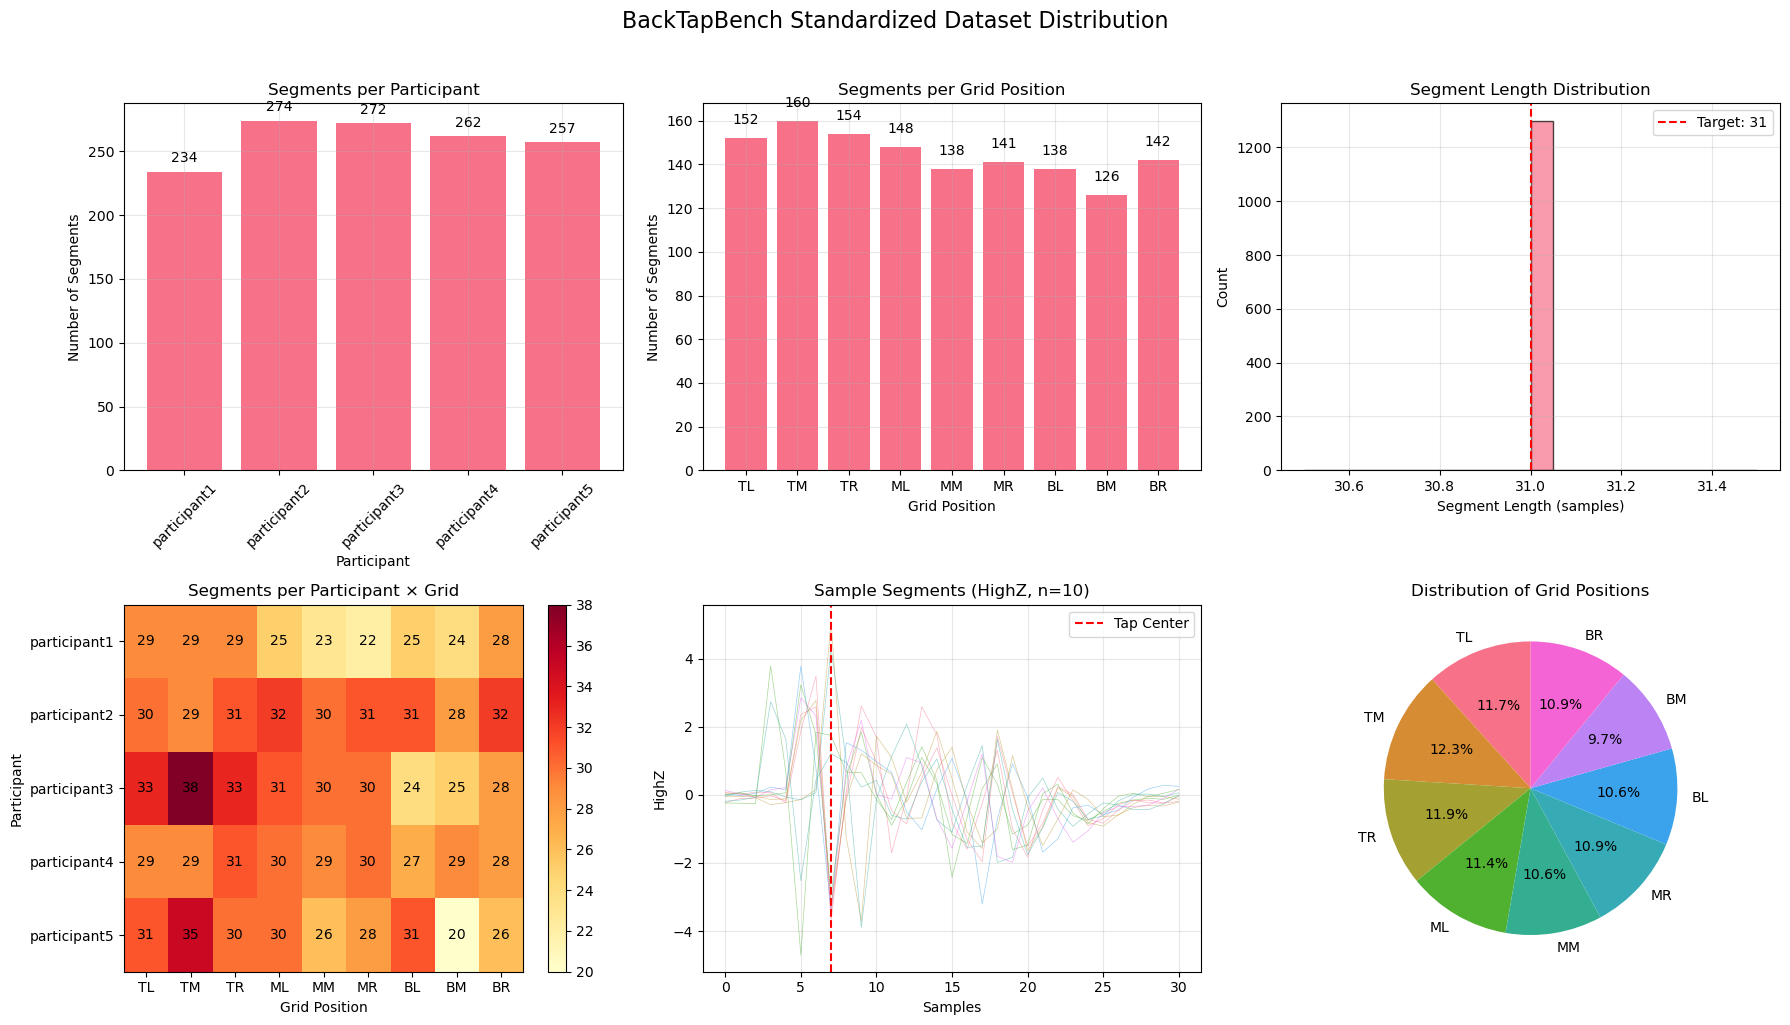

✅ Distribution plot saved: dataset_distribution.png


In [57]:
# Visualize if we have data
if total_segments > 0:
    visualize_data_distribution(standardizer)

## 5. Save Standardized Dataset

In [85]:
# Save the standardized dataset
standardizer.save_standardized_data()


💾 SAVING STANDARDIZED DATA...
✅ Main data saved: backtapbench_data.npz
   Shape: (1299, 31, 10)
   Segments: 1299
   Labels: 1299 (0-8)
✅ Metadata saved: metadata.json (1299 entries)
✅ Statistics saved: dataset_statistics.json
✅ Pickle file saved: backtapbench_dataset.pkl
✅ Summary CSV saved: dataset_summary.csv

🔧 EXTRACTING FEATURES...
✅ Features saved:
   - statistical_features.csv (1299 samples, 155 features)
   - feature_matrix.npy ((1299, 155))
   - feature_names.json

📊 CREATING DATASET SPLITS...
✅ Dataset splits saved: dataset_splits.json
   - Within-participant folds: 5
   - Leave-one-participant-out: 5
   - Random 80/20 split: 1
✅ README generated: README.md

STANDARDIZATION COMPLETE!


## 6. Data Loading Examples

In [16]:
def demonstrate_data_loading():
    """
    Demonstrate how to load and use the standardized dataset
    """
    print("\n" + "=" * 60)
    print("DATA LOADING EXAMPLES")
    print("=" * 60)
    
    # Method 1: Load from NPZ
    print("\n📥 METHOD 1: Load from NPZ file")
    print("```python")
    print("import numpy as np")
    print("data = np.load('backtapbench_standard/backtapbench_data.npz')")
    print("segments = data['segments']")
    print("labels = data['labels']")
    print("participants = data['participants']")
    print("print(f'Segments shape: {segments.shape}')")
    print("print(f'Labels: {len(labels)}')")
    print("```")
    
    # Method 2: Load from pickle
    print("\n📥 METHOD 2: Load from pickle")
    print("```python")
    print("import pickle")
    print("with open('backtapbench_standard/backtapbench_dataset.pkl', 'rb') as f:")
    print("    dataset = pickle.load(f)")
    print("segments = dataset['segments']")
    print("labels = dataset['labels']")
    print("sensor_columns = dataset['sensor_columns']")
    print("```")
    
    # Method 3: Load features
    print("\n📥 METHOD 3: Load extracted features")
    print("```python")
    print("import pandas as pd")
    print("features = pd.read_csv('backtapbench_standard/features/statistical_features.csv')")
    print("X = features.drop(['label', 'participant', 'grid_position', 'segment_id'], axis=1)")
    print("y = features['label']")
    print("```")
    
    # Method 4: Load splits
    print("\n📥 METHOD 4: Load pre-defined splits")
    print("```python")
    print("import json")
    print("with open('backtapbench_standard/splits/dataset_splits.json', 'r') as f:")
    print("    splits = json.load(f)")
    print("# Example: Get LOPO split for participant1")
    print("split = splits['lopout_participant1']")
    print("train_indices = split['train']")
    print("test_indices = split['test']")
    print("```")
    
    # Actual loading example
    print("\n🔧 ACTUAL LOADING DEMONSTRATION:")
    
    try:
        # Load the data we just created
        data_path = os.path.join(OUTPUT_PATH, 'backtapbench_data.npz')
        data = np.load(data_path)
        
        print(f"Loaded data keys: {list(data.keys())}")
        print(f"Segments shape: {data['segments'].shape}")
        print(f"Labels shape: {data['labels'].shape}")
        print(f"Unique labels: {np.unique(data['labels'])}")
        print(f"Unique participants: {np.unique(data['participants'])}")
        
        # Show a sample segment
        print(f"\nSample segment (index 0):")
        print(f"  Shape: {data['segments'][0].shape}")
        print(f"  Label: {data['labels'][0]}")
        print(f"  Participant: {data['participants'][0]}")
        print(f"  Grid: {data['grids'][0]}")
        
    except Exception as e:
        print(f"Error loading data: {e}")

In [17]:
demonstrate_data_loading()


DATA LOADING EXAMPLES

📥 METHOD 1: Load from NPZ file
```python
import numpy as np
data = np.load('backtapbench_standard/backtapbench_data.npz')
segments = data['segments']
labels = data['labels']
participants = data['participants']
print(f'Segments shape: {segments.shape}')
print(f'Labels: {len(labels)}')
```

📥 METHOD 2: Load from pickle
```python
import pickle
with open('backtapbench_standard/backtapbench_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)
segments = dataset['segments']
labels = dataset['labels']
sensor_columns = dataset['sensor_columns']
```

📥 METHOD 3: Load extracted features
```python
import pandas as pd
features = pd.read_csv('backtapbench_standard/features/statistical_features.csv')
X = features.drop(['label', 'participant', 'grid_position', 'segment_id'], axis=1)
y = features['label']
```

📥 METHOD 4: Load pre-defined splits
```python
import json
with open('backtapbench_standard/splits/dataset_splits.json', 'r') as f:
    splits = json.load(f)
# Example: 

## 7. Quality Check

In [19]:
def perform_quality_checks():
    """
    Perform quality checks on the standardized dataset
    """
    print("\n" + "=" * 60)
    print("QUALITY CHECKS")
    print("=" * 60)
    
    checks_passed = 0
    total_checks = 0
    
    # Check 1: Data files exist
    total_checks += 1
    required_files = [
        'backtapbench_data.npz',
        'metadata.json',
        'dataset_statistics.json',
        'README.md'
    ]
    
    missing_files = []
    for file in required_files:
        if not os.path.exists(os.path.join(OUTPUT_PATH, file)):
            missing_files.append(file)
    
    if len(missing_files) == 0:
        print("✅ Check 1: All required files exist")
        checks_passed += 1
    else:
        print(f"❌ Check 1: Missing files: {missing_files}")
    
    # Check 2: Segment shape consistency
    total_checks += 1
    try:
        data = np.load(os.path.join(OUTPUT_PATH, 'backtapbench_data.npz'))
        segments = data['segments']
        
        if len(set([s.shape for s in segments])) == 1:
            print(f"✅ Check 2: All segments have consistent shape: {segments[0].shape}")
            checks_passed += 1
        else:
            print(f"❌ Check 2: Inconsistent segment shapes")
            shapes = set([s.shape for s in segments])
            for shape in shapes:
                count = sum([1 for s in segments if s.shape == shape])
                print(f"   Shape {shape}: {count} segments")
    except:
        print("❌ Check 2: Could not check segment shapes")
    
    # Check 3: Label range
    total_checks += 1
    labels = data['labels']
    unique_labels = np.unique(labels)
    
    if set(unique_labels) == set(range(9)):
        print(f"✅ Check 3: All 9 grid positions represented (0-8)")
        checks_passed += 1
    else:
        missing = set(range(9)) - set(unique_labels)
        extra = set(unique_labels) - set(range(9))
        print(f"❌ Check 3: Label issues")
        if missing:
            print(f"   Missing labels: {missing}")
        if extra:
            print(f"   Extra labels: {extra}")
    
    # Check 4: No NaN values
    total_checks += 1
    if not np.isnan(segments).any():
        print("✅ Check 4: No NaN values in segments")
        checks_passed += 1
    else:
        nan_count = np.isnan(segments).sum()
        print(f"❌ Check 4: Found {nan_count} NaN values in segments")
    
    # Check 5: Balanced distribution
    total_checks += 1
    label_counts = np.bincount(labels.astype(int))
    min_count = np.min(label_counts)
    max_count = np.max(label_counts)
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
    
    if imbalance_ratio < 1.5:  # Less than 50% imbalance
        print(f"✅ Check 5: Labels reasonably balanced (ratio: {imbalance_ratio:.2f})")
        checks_passed += 1
    else:
        print(f"⚠️  Check 5: Label imbalance detected (ratio: {imbalance_ratio:.2f})")
        for i, count in enumerate(label_counts):
            print(f"   Grid {i}: {count} samples")
    
    # Summary
    print("\n" + "=" * 60)
    print(f"QUALITY CHECK SUMMARY: {checks_passed}/{total_checks} passed")
    
    if checks_passed == total_checks:
        print("🎉 All quality checks passed! Dataset is ready for use.")
    else:
        print("⚠️  Some checks failed. Review warnings above.")
    
    return checks_passed, total_checks

In [20]:
quality_passed, quality_total = perform_quality_checks()


QUALITY CHECKS
✅ Check 1: All required files exist
✅ Check 2: All segments have consistent shape: (31, 10)
✅ Check 3: All 9 grid positions represented (0-8)
✅ Check 4: No NaN values in segments
✅ Check 5: Labels reasonably balanced (ratio: 1.27)

QUALITY CHECK SUMMARY: 5/5 passed
🎉 All quality checks passed! Dataset is ready for use.


## 8. Next Steps Instructions

In [22]:
def generate_next_steps():
    """
    Generate instructions for next steps
    """
    print("\n" + "=" * 80)
    print("NEXT STEPS FOR BACKTAPBENCH")
    print("=" * 80)

    print("\n🎯 YOUR STANDARDIZED DATASET IS READY!")
    print(f"Location: {OUTPUT_PATH}")
    
    print("\n📚 NEXT NOTEBOOKS TO RUN:")
    print("""
    04_dtw_knn_benchmark.ipynb      - Your existing DTW+KNN algorithm
    05_random_forest_features.ipynb - Random Forest on extracted features  
    06_cnn_1d_implementation.ipynb  - 1D CNN on raw time-series
    07_evaluation_framework.ipynb   - Unified evaluation of all methods
    08_results_visualization.ipynb  - Generate figures and final results
    """)
    
    print("🔧 QUICK START EXAMPLE:")
    print("""
    # Load your standardized data
    import numpy as np
    data = np.load('backtapbench_standard/backtapbench_data.npz')
    X = data['segments']  # Shape: (n_samples, 31, 10)
    y = data['labels']    # Shape: (n_samples,)
    
    # Or load features for classical ML
    import pandas as pd
    features = pd.read_csv('backtapbench_standard/features/statistical_features.csv')
    X_features = features.drop(['label', 'participant', 'grid_position', 'segment_id'], axis=1)
    y_features = features['label']
    """)
    
    print("\n📊 DATASET STATISTICS:")
    try:
        with open(os.path.join(OUTPUT_PATH, 'dataset_statistics.json'), 'r') as f:
            stats = json.load(f)
        
        print(f"  Total segments: {stats['total_segments']}")
        print(f"  Unique participants: {stats['unique_participants']}")
        print(f"  Segment shape: {stats['segment_shape_final']}")
        
        # Show segments per participant
        print(f"\n  Segments per participant:")
        for participant, count in stats['segments_per_participant'].items():
            print(f"    {participant}: {count}")
            
    except:
        print("  (Statistics not available)")
    
    print("\n" + "=" * 80)
    print("✅ STANDARDIZATION COMPLETE!")
    print("=" * 80)

In [23]:
generate_next_steps()


NEXT STEPS FOR BACKTAPBENCH

🎯 YOUR STANDARDIZED DATASET IS READY!
Location: C:\Users\jumia\Downloads\BackTap\backtapbench_standard

📚 NEXT NOTEBOOKS TO RUN:

    04_dtw_knn_benchmark.ipynb      - Your existing DTW+KNN algorithm
    05_random_forest_features.ipynb - Random Forest on extracted features  
    06_cnn_1d_implementation.ipynb  - 1D CNN on raw time-series
    07_evaluation_framework.ipynb   - Unified evaluation of all methods
    08_results_visualization.ipynb  - Generate figures and final results
    
🔧 QUICK START EXAMPLE:

    # Load your standardized data
    import numpy as np
    data = np.load('backtapbench_standard/backtapbench_data.npz')
    X = data['segments']  # Shape: (n_samples, 31, 10)
    y = data['labels']    # Shape: (n_samples,)
    
    # Or load features for classical ML
    import pandas as pd
    features = pd.read_csv('backtapbench_standard/features/statistical_features.csv')
    X_features = features.drop(['label', 'participant', 'grid_position', 's

## 9. Export Configuration for Other Notebooks

In [25]:
# Export configuration for use in other notebooks
config = {
    'data_path': DATA_PATH,
    'output_path': OUTPUT_PATH,
    'participants': PARTICIPANTS,
    'sensor_columns': SENSOR_COLS,
    'segment_length': SEGMENT_LENGTH,
    'sampling_rate': SAMPLING_RATE,
    'pre_samples': PRE_SAMPLES,
    'post_samples': POST_SAMPLES,
    'window_size': WINDOW_SIZE,
    'z_energy_threshold': Z_ENERGY_THRESHOLD,
    'gyro_threshold': GYRO_THRESHOLD,
    'debounce_samples': DEBOUNCE_SAMPLES
}

with open('dataset_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("✅ Configuration exported to: dataset_config.json")

# Save the standardizer object for reuse
with open('standardizer.pkl', 'wb') as f:
    pickle.dump(standardizer, f)

print("✅ Standardizer object saved to: standardizer.pkl")

print("\n" + "=" * 80)
print("🎉 NOTEBOOK 3 COMPLETE!")
print("=" * 80)
print("\nYour BackTapBench dataset is now standardized and ready for benchmarking!")
print(f"Check the folder: {OUTPUT_PATH}")
print("\nProceed to Notebook 4 to run your DTW+KNN algorithm on this standardized data.")

✅ Configuration exported to: dataset_config.json
✅ Standardizer object saved to: standardizer.pkl

🎉 NOTEBOOK 3 COMPLETE!

Your BackTapBench dataset is now standardized and ready for benchmarking!
Check the folder: C:\Users\jumia\Downloads\BackTap\backtapbench_standard

Proceed to Notebook 4 to run your DTW+KNN algorithm on this standardized data.


## **What This Notebook Does:**

1. **Processes all 5 participants** and extracts tap segments
2. **Creates standardized format** in `backtapbench_standard/` folder
3. **Extracts features** for classical ML algorithms
4. **Creates pre-defined splits** for evaluation
5. **Generates comprehensive metadata** and documentation
6. **Performs quality checks** on the standardized data
7. **Provides loading examples** for future notebooks

## **Output Structure Created:**
backtapbench_standard/

├── backtapbench_data.npz # Main dataset

├── backtapbench_dataset.pkl # Python pickle

├── metadata.json # Detailed metadata

├── dataset_statistics.json # Statistics

├── dataset_summary.csv # CSV summary

├── README.md # Documentation

├── dataset_distribution.png # Visualization

├── features/ # Extracted features

│ ├── statistical_features.csv

│ ├── feature_matrix.npy

│ └── feature_names.json

└── splits/ # Dataset splits

└── dataset_splits.json

## **Next Steps:**

1. **Run this notebook** to create your standardized dataset
2. **Check the output folder** to verify everything was created
3. **Proceed to Notebook 4** (DTW+KNN benchmark) which will use this standardized data
